In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# --- Load the datasets ---
DATA_DIR = "/content"

print("Loading datasets...")
with np.load(f"{DATA_DIR}/train.npz") as data:
    X_train = data['X']
    y_train = data['y']

with np.load(f"{DATA_DIR}/validation.npz") as data:
    X_val = data['X']
    y_val = data['y']

with np.load(f"{DATA_DIR}/test.npz") as data:
    X_test = data['X']
    y_test = data['y']

print("Datasets loaded successfully!")
print(f"Training set shape:   X={X_train.shape}, y={y_train.shape}")
print(f"Validation set shape: X={X_val.shape}, y={y_val.shape}")
print(f"Test set shape:       X={X_test.shape}, y={y_test.shape}")

Loading datasets...
Datasets loaded successfully!
Training set shape:   X=(56, 128, 128, 1), y=(56, 128, 128, 3)
Validation set shape: X=(12, 128, 128, 1), y=(12, 128, 128, 3)
Test set shape:       X=(12, 128, 128, 1), y=(12, 128, 128, 3)


In [3]:
def build_unet_model(input_shape, num_classes):
    """
    Builds a U-Net model using the Keras functional API.
    """
    inputs = tf.keras.layers.Input(input_shape)

    # --- Encoder (Contracting Path) ---
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    # --- Bottleneck ---
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)

    # --- Decoder (Expansive Path) ---
    u4 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c3)
    u4 = tf.keras.layers.concatenate([u4, c2]) # Skip connection
    c4 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u4)
    c4 = tf.keras.layers.Dropout(0.1)(c4)
    c4 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)

    u5 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = tf.keras.layers.concatenate([u5, c1]) # Skip connection
    c5 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u5)
    c5 = tf.keras.layers.Dropout(0.1)(c5)
    c5 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # --- Output Layer ---
    # num_classes is 3 for our 3 output fields (Cp, Ux, Uy)
    outputs = tf.keras.layers.Conv2D(num_classes, (1, 1), activation='linear')(c5)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    return model

# Get the input shape and number of output channels from your data
INPUT_SHAPE = X_train.shape[1:]
OUTPUT_CHANNELS = y_train.shape[-1]

# Build the model and print its summary
model = build_unet_model(INPUT_SHAPE, OUTPUT_CHANNELS)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        160 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      2,320 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │      9,248 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     36,928 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 64, 64,    │      8,224 │ conv2d_5[0][0]    │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 64)               │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │     18,464 │ concatenate[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_6[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 64, 64,    │      9,248 │ dropout_3[0][0] 

 Total params: 116,787 (456.20 KB)

 Trainable params: 116,787 (456.20 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# --- Compile the model ---
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_absolute_error'])

# --- Train the model ---
EPOCHS = 25
BATCH_SIZE = 16

history = model.fit(X_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_val, y_val))

# --- Save the trained model for later use ---
model.save("airfoil_surrogate_model.h5")
print("\n✅ Training complete and model saved!")

Epoch 1/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - loss: 0.4507 - mean_absolute_error: 0.6210 - val_loss: 0.3677 - val_mean_absolute_error: 0.5442
Epoch 2/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - loss: 0.3435 - mean_absolute_error: 0.5247 - val_loss: 0.2150 - val_mean_absolute_error: 0.3992
Epoch 3/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: 0.1703 - mean_absolute_error: 0.3481 - val_loss: 0.0755 - val_mean_absolute_error: 0.2174
Epoch 4/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - loss: 0.0727 - mean_absolute_error: 0.2126 - val_loss: 0.0819 - val_mean_absolute_error: 0.2371
Epoch 5/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - loss: 0.0727 - mean_absolute_error: 0.2183 - val_loss: 0.0713 - val_mean_absolute_error: 0.2067
Epoch 6/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - loss: 0.0678 - mean_absolute_error: 0.2036 - val_loss: 0.0647 - val_mean_absolute_error: 0.2035
Epoch 7/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - loss: 0.0611 - mean_absolute_error: 0.1970 - val_loss: 0.0624 - val_mean_abs


✅ Training complete and model saved!


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - loss: 0.0374 - mean_absolute_error: 0.1457

Test Set Mean Absolute Error: 0.1457


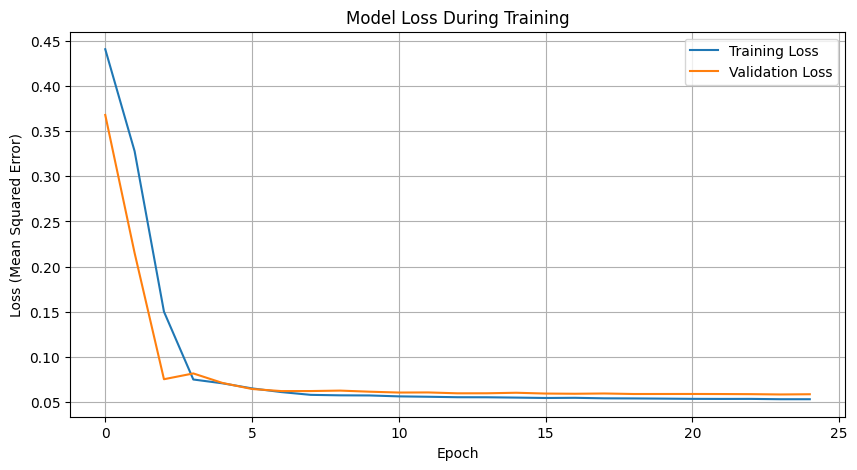

In [5]:
# --- Evaluate on the test set ---
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"\nTest Set Mean Absolute Error: {test_mae:.4f}")

# --- Plot training and validation loss ---
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.ylabel('Loss (Mean Squared Error)')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

Loading data from /content/train.npz...
Data loaded successfully.
Visualizing sample #23

✅ Visualization saved as training_sample_visualization.png


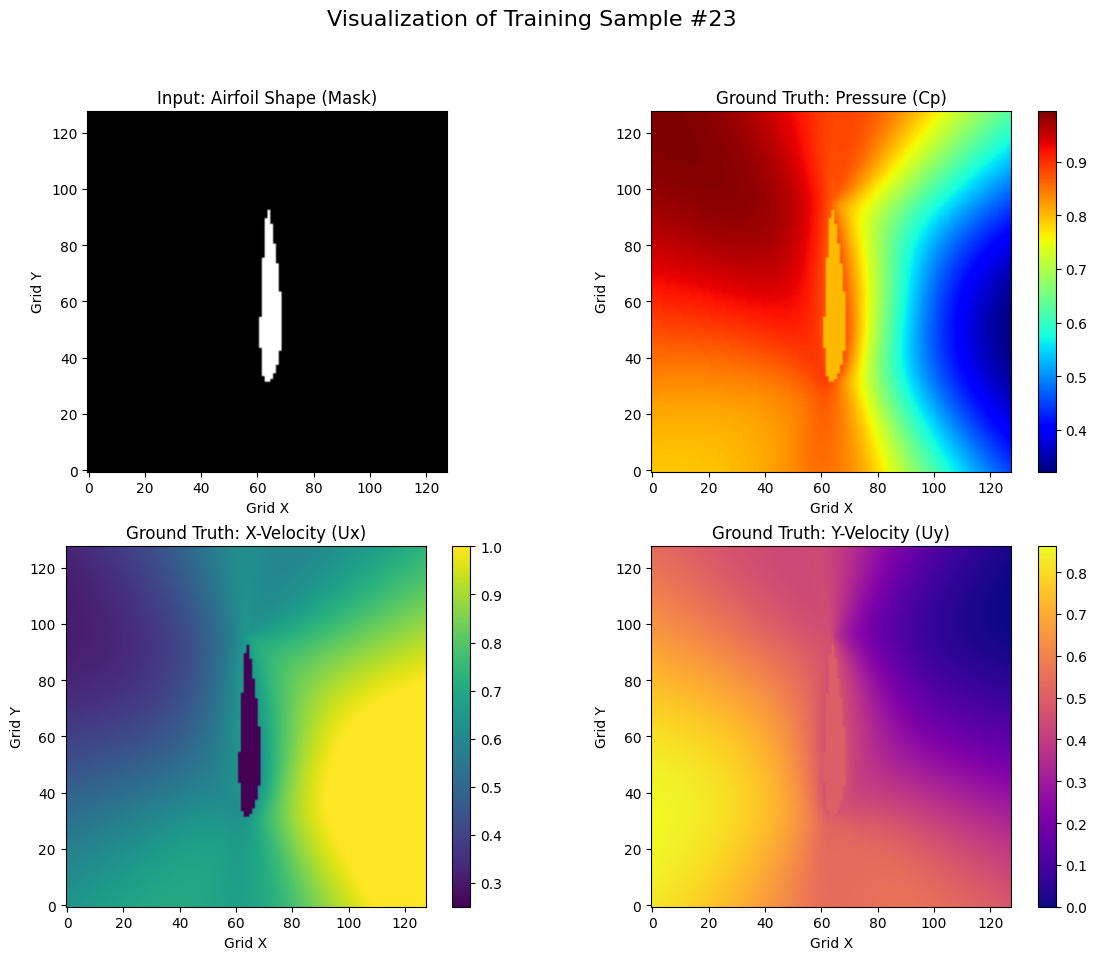

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import os

# --- Configuration ---
DATA_DIR = "/content"
TRAIN_FILE = "train.npz"
file_path = os.path.join(DATA_DIR, TRAIN_FILE)

# --- 1. Load the Training Data ---
if os.path.exists(file_path):
    print(f"Loading data from {file_path}...")
    with np.load(file_path) as data:
        X_train = data['X']
        y_train = data['y']
    print("Data loaded successfully.")

    # --- 2. Select a Random Sample ---
    # Choose a random index for the sample to visualize
    sample_index = np.random.randint(0, len(X_train))
    print(f"Visualizing sample #{sample_index}")

    input_mask = X_train[sample_index, :, :, 0]
    output_fields = y_train[sample_index]

    # --- 3. Create the Visualization ---
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle(f"Visualization of Training Sample #{sample_index}", fontsize=16)

    # Plot 1: Input Airfoil Shape (Mask)
    im1 = axs[0, 0].imshow(input_mask.T, origin='lower', cmap='gray')
    axs[0, 0].set_title("Input: Airfoil Shape (Mask)")
    axs[0, 0].set_xlabel("Grid X")
    axs[0, 0].set_ylabel("Grid Y")

    # Plot 2: Ground Truth Pressure (Cp)
    cp_field = output_fields[:, :, 0]
    im2 = axs[0, 1].imshow(cp_field.T, origin='lower', cmap='jet')
    fig.colorbar(im2, ax=axs[0, 1])
    axs[0, 1].set_title("Ground Truth: Pressure (Cp)")
    axs[0, 1].set_xlabel("Grid X")
    axs[0, 1].set_ylabel("Grid Y")

    # Plot 3: Ground Truth X-Velocity (Ux)
    ux_field = output_fields[:, :, 1]
    im3 = axs[1, 0].imshow(ux_field.T, origin='lower', cmap='viridis')
    fig.colorbar(im3, ax=axs[1, 0])
    axs[1, 0].set_title("Ground Truth: X-Velocity (Ux)")
    axs[1, 0].set_xlabel("Grid X")
    axs[1, 0].set_ylabel("Grid Y")

    # Plot 4: Ground Truth Y-Velocity (Uy)
    uy_field = output_fields[:, :, 2]
    im4 = axs[1, 1].imshow(uy_field.T, origin='lower', cmap='plasma')
    fig.colorbar(im4, ax=axs[1, 1])
    axs[1, 1].set_title("Ground Truth: Y-Velocity (Uy)")
    axs[1, 1].set_xlabel("Grid X")
    axs[1, 1].set_ylabel("Grid Y")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig("training_sample_visualization.png")
    print("\n✅ Visualization saved as training_sample_visualization.png")

else:
    print(f"Error: The file '{file_path}' was not found.")
    print("Please make sure you have run the data creation script successfully.")